In [1]:
import os
import sys
import torch 
import pickle
import numpy as np
from tqdm import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

path = '../../gld/train-data-probes/data/12b'

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# with open(os.path.join(path, 'mem_all_generations.pkl'), 'rb') as f:
#     generations = pickle.load(f)

with open(os.path.join(path, 'mem_all_mem_status.pkl'), 'rb') as f:
    status = pickle.load(f)

with open(os.path.join(path, 'pile_all_mem_status.pkl'), 'rb') as f:
    pile_status = pickle.load(f)

print(len(status), len(pile_status))
sum(status)/len(status), sum(pile_status)/len(pile_status)

4988 4967


(0.9366886778267843, 0.5713647573988323)

In [3]:
def gen_pile_data(N, tokenizer, min_n_toks : int = None):
    pile = load_dataset('EleutherAI/the_pile_deduplicated', split='train', streaming=True)
    sentences = []

    counter = 0
    for i, example in enumerate(pile):
        if min_n_toks is not None:
            toks = tokenizer(example['text'])['input_ids']
            if len(toks) > min_n_toks:
                sentences.append(example['text'])
                counter +=1
        else:
            sentences.append(example['text'])
            counter +=1
        
        if counter == N:
            break

    return sentences

N_PROMPTS = 5000
model_name = "EleutherAI/pythia-12b"
dataset_name = "duped." + model_name.split("-")[-1]
tokenizer = AutoTokenizer.from_pretrained(model_name)

mem_data = load_dataset('EleutherAI/pythia-memorized-evals')[dataset_name]
mem_data_toks = [seq for seq in mem_data[:N_PROMPTS]['tokens']]
pile_prompts = gen_pile_data(N_PROMPTS, tokenizer, min_n_toks = 64)

print(len(pile_prompts))
print(len(mem_data_toks))
    
tok_idxs =  (7 * np.arange(10)).tolist() #every 5th token
tok_idxs[-1]= tok_idxs[-1] - 1 #goes from 63 to 62
print(tok_idxs)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Resolving data files: 100%|██████████| 1650/1650 [00:01<00:00, 848.33it/s]


5000
5000
[0, 7, 14, 21, 28, 35, 42, 49, 56, 62]


In [4]:
import pandas as pd

# load from csv
df = pd.read_csv(os.path.join(path, 'mem_evals_gen_data.csv'))
mem_df = df[:len(status)]
pile_df = df[len(status):]

# sort mem df by mem_status col
mem_df = mem_df.sort_values(by=['char_by_char_similarity'], ascending=True)
pd.set_option('display.max_colwidth', None)
# mem_df.head(105)


In [5]:
# char_similarity = []
# for i in tqdm(range(len(df))): 
#     gen = df['gen'][i]
#     ground = df['ground'][i]
    
#     # remove all whitespace 
#     gen = ''.join(gen.split())
#     ground = ''.join(ground.split())

#     # lowercase 
#     gen = gen.lower()
#     ground = ground.lower()

#     # remove '<|endoftext|>'
#     gen = gen.replace('<|endoftext|>', '')
#     ground = ground.replace('<|endoftext|>', '')

#     max_len = max(len(gen), len(ground))
#     matches = [c1 == c2 for c1, c2 in zip(gen, ground)]
#     char_similarity.append(sum(matches)/max_len if max_len > 0 else 0)

# df['char_by_char_similarity'] = char_similarity
# df.head()

# df.to_csv(os.path.join(path, 'mem_evals_gen_data.csv'), index=False)

In [6]:
pile_df.sort_values(by=['char_by_char_similarity'], ascending=False, inplace=True)

# # remove mem_status=1.0
# pile_df = pile_df[pile_df['mem_status'] != 1.0]
# pile_df.head(2000)

/tmp/ipykernel_13243/1807540886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pile_df.sort_values(by=['char_by_char_similarity'], ascending=False, inplace=True)


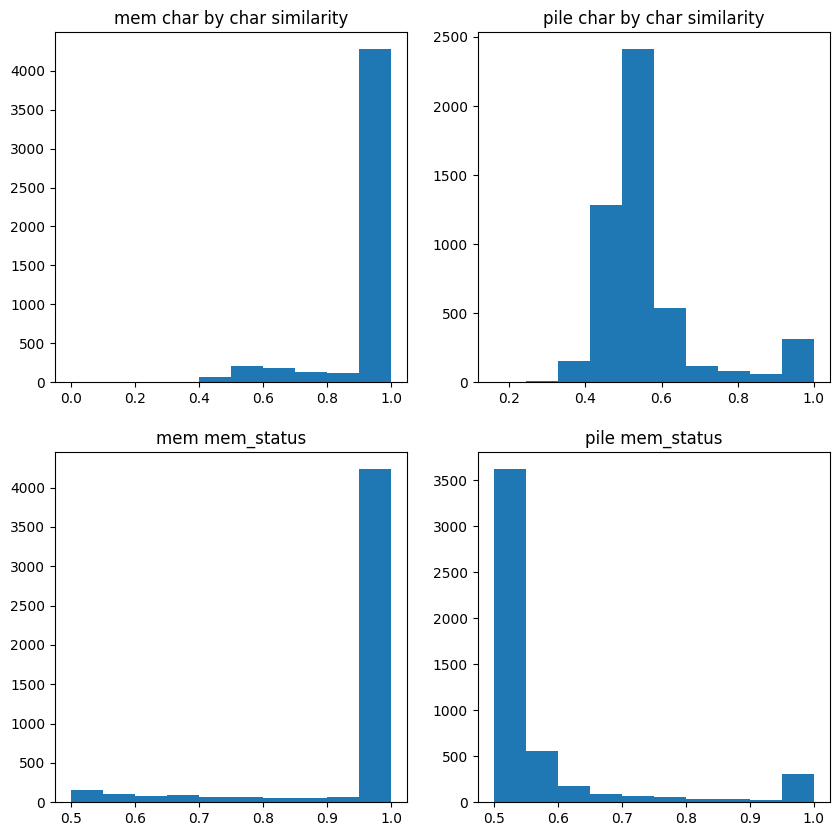

In [7]:
# hist of mem_status for each
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].hist(mem_df['char_by_char_similarity'])
ax[0,1].hist(pile_df['char_by_char_similarity'])
ax[1,0].hist(mem_df['mem_status'])
ax[1,1].hist(pile_df['mem_status'])
ax[0,0].set_title('mem char by char similarity')
ax[0,1].set_title('pile char by char similarity')
ax[1,0].set_title('mem mem_status')
ax[1,1].set_title('pile mem_status')
plt.show()



### make train dataset

In [8]:
# # only keep pile_df with char_by_char_similarity = 0.5
# new_pile_df = pile_df[pile_df['char_by_char_similarity'] <= 0.55]
# extras = mem_df[mem_df['char_by_char_similarity'] <= 0.55]

# # only keep mem_df with char_by_char_similarity = 1.0
# new_mem_df = mem_df[mem_df['char_by_char_similarity'] == 1]

# print(len(new_mem_df), len(new_pile_df), len(extras))

neg = df[df['char_by_char_similarity'] <= 0.55]
pos = df[df['char_by_char_similarity'] == 1]

print(len(neg), len(pos))

min_len = min(len(neg), len(pos))

positive_idxs = pos.index.tolist()
negative_idxs = neg.index.tolist()

# sample 
import numpy as np
np.random.seed(0)
positive_idxs = np.random.choice(positive_idxs, min_len, replace=False)
negative_idxs = np.random.choice(negative_idxs, min_len, replace=False)

3373 4306


In [9]:
pile_tokens = []
for i in tqdm(range(len(pile_prompts))): 
    prompt = pile_prompts[i]
    toks = tokenizer(prompt)['input_ids']
    pile_tokens.append(toks)

100%|██████████| 5000/5000 [00:23<00:00, 212.99it/s]


In [10]:
tokens = mem_data_toks + pile_tokens
final_tokens = []
labels = []
for i in tqdm(positive_idxs): 
    final_tokens.append(tokens[i])
    labels.append(1)
for i in tqdm(negative_idxs):
    final_tokens.append(tokens[i])
    labels.append(0)

print(len(final_tokens), len(labels), len(positive_idxs), len(negative_idxs))

100%|██████████| 3373/3373 [00:00<00:00, 1834226.29it/s]

6746 6746 3373 3373


In [11]:
print(sum(labels)/len(labels))  

0.5


In [12]:
# create a huggingface dataset
from datasets import Dataset
idxs = positive_idxs.tolist() + negative_idxs.tolist()
dataset = Dataset.from_dict({'input_ids': final_tokens, 'labels': labels, 'df_ref_idx': idxs})
dataset.save_to_disk(os.path.join(path, 'hf_token_dataset_v2'))

Saving the dataset (1/1 shards): 100%|██████████| 6746/6746 [00:00<00:00, 118689.62 examples/s]


In [13]:
from datasets import load_from_disk, DatasetDict
import numpy as np

seed = 0
np.random.seed(seed)

path = '../../gld/train-data-probes/data/12b'
dataset = load_from_disk(os.path.join(path, 'hf_token_dataset_v2'))

dataset = dataset.shuffle(seed=seed)
dataset = dataset.train_test_split(test_size=0.3)
test = dataset['test']
temp = dataset['train'].train_test_split(test_size=1/7)
train = temp['train']
val = temp['test']
dataset = DatasetDict({'train': train, 'val': val, 'test': test})

# cutoff after 64 tokens
input_ids = {'train': [], 'val': [], 'test': []}
labels = {'train': [], 'val': [], 'test': []}
df_ref_idx = {'train': [], 'val': [], 'test': []}
for cutoff in tok_idxs[5:]: 
    print(cutoff)
    for split in ['train', 'val', 'test']:
        input_ids[split].extend([x[:cutoff] for x in dataset[split]['input_ids']])
        labels[split].extend(dataset[split]['labels'])
        df_ref_idx[split].extend(dataset[split]['df_ref_idx'])

dataset = DatasetDict({'train': Dataset.from_dict({'input_ids': input_ids['train'], 'labels': labels['train'], 'df_ref_idx': df_ref_idx['train']}), 
                          'val': Dataset.from_dict({'input_ids': input_ids['val'], 'labels': labels['val'], 'df_ref_idx': df_ref_idx['val']}), 
                          'test': Dataset.from_dict({'input_ids': input_ids['test'], 'labels': labels['test'], 'df_ref_idx': df_ref_idx['test']})})

35
42
49
56
62


In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 20235
    })
    val: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 3375
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 10120
    })
})

In [17]:
dataset.save_to_disk(os.path.join(path, 'split_hf_token_dataset_vary_len_v2'))

Saving the dataset (1/1 shards): 100%|██████████| 10120/10120 [00:00<00:00, 1411913.53 examples/s]


### make generalization datasets

In [18]:
import numpy as np
seed = 0
np.random.seed(seed)

In [19]:
hard_pos = df[df['char_by_char_similarity'] != 1]
hard_pos = hard_pos[hard_pos['char_by_char_similarity'] >= 0.8]
                    
positive_idxs = hard_pos.index.tolist()

print(len(hard_pos))

502


In [20]:
hard_pos.sort_values(by=['char_by_char_similarity'], ascending=True, inplace=True)

hard_pos.head(10)

,gen,ground,mem_status,source,idx_in_ground,idx_in_hidden_states,char_by_char_similarity
3045,6015(f):\n\n (a) Marital status. The requesting spouse is\n separated (whether legally separated or living apart)\n or divorced from the nonrequesting spouse.\n\n (b) Economic hardship. The requesting spouse\n demonstrates that the separation (whether legal or\n,6015(f):\n\n (a) Marital status. The requesting spouse is\n separated (whether legally separated or living apart)\n or divorced from the nonrequesting spouse.\n\n (b) Economic hardship. The requesting spouse\n would suffer economic hardship (within the meaning of\n,0.859375,pythia-evals,3050,3045,0.800000
3059,xc0206911\n\tSIOCGIFGENERIC = 0xc020693a\n\tSIOCGIFGMEMB = 0xc024698a\n\tSIOCGIFGROUP = 0xc0246988\n\tSIOCGIFHARDMTU = 0xc02069a5\n,xc0206911\n\tSIOCGIFGENERIC = 0xc020693a\n\tSIOCGIFGMEMB = 0xc024698a\n\tSIOCGIFGROUP = 0xc0246988\n\tSIOCGIFINDEX = 0xc0206920\n\tSIOCGIF,0.796875,pythia-evals,3064,3059,0.800000
101,"�': '9',\n '०': '0'\n };\n\n var ne = moment.defineLocale('ne', {\n months : 'जनवरी_फ़रवरी_मार्च_अप्रै","�': '9',\n '०': '0'\n };\n\n var ne = moment.defineLocale('ne', {\n months : 'जनवरी_फेब्रुवरी_मार्च_अप",0.718750,pythia-evals,101,101,0.800000
973,</string>\n <key>NSExtension</key>\n <dict>\n <key>NSExtensionAttributes</key>\n <dict>\n <key>NSExtensionActivationRule</key>\n <string>NSExtensionActivation,</string>\n <key>NSExtension</key>\n <dict>\n <key>NSExtensionAttributes</key>\n <dict>\n <key>NSExtensionActivationRule</key>\n <dict>\n <key>N,0.890625,pythia-evals,974,973,0.800000
4222,"=""Skip navigation links"">Skip navigation links</a></div>\n<a name=""navbar.top.firstrow"">\n<!-- -->\n</a>\n<ul class=""navList"" title=""Navigation"">\n<li><a href=""../../../../../../../overview-summary.html"">Overview</a></li","=""Skip navigation links"">Skip navigation links</a></div>\n<a name=""navbar.top.firstrow"">\n<!-- -->\n</a>\n<ul class=""navList"" title=""Navigation"">\n<li><a href=""../../../../../../overview-summary.html"">Overview</a></li>",0.812500,pythia-evals,4232,4222,0.800995
7163,"\nTEXAS COURT OF APPEALS, THIRD DISTRICT, AT AUSTIN\n\n\n\n\n\nNO. 03-00-00243-CR\n\n\n\n\n\nEdward Bell, Appellant\n\n\nv.\n\n\nThe State of Texas, Appellee\n\n\n\n\n\nFROM THE DISTRICT COURT OF TRAVIS COUNTY, 147TH JUDICIAL DISTRICT\n","\nTEXAS COURT OF APPEALS, THIRD DISTRICT, AT AUSTIN\n\n\n\n\n\nNO. 03-00-00243-CR\n\n\n\n\n\nEdward Bell, Appellant\n\n\n\nv.\n\n\n\nThe State of Texas, Appellee\n\n\n\n\n\n\nFROM THE DISTRICT COURT OF TOM GREEN COUNTY, 119TH JUDIC",0.687500,pile,2188,2175,0.801242
6314,"In English-----------Hail holy queen, mother of mercy,Hail our life, our sweetness and our hope.To you do we cry poor banished children of Eve,To you do we send up our sighs, mourning and weepingIn this valley of tears, where you have laid us downIn the midst of","In English-----------Hail holy queen, mother of mercy,Hail our life, our sweetness and our hope.To you do we cry poor banished children of Eve,To you do we send up our sighs, mourning and weeping in this valley of tears.Turn then, most gracious advocateyour eyes of mercy",0.812500,pile,1331,1326,0.801762
5645,// Copyright 2014 The Chromium Authors. All rights reserved.\n// Use of this source code is governed by a BSD-style license that can be\n// found in the LICENSE file.\n\n#ifndef COMPONENTS_SIGNIN_CORE_BROWSER_SIGNIN_USER_MANA,// Copyright 2014 The Chromium Authors. All rights reserved.\n// Use of this source code is governed by a BSD-style license that can be\n// found in the LICENSE file.\n\n#ifndef COMPONENTS_DATA_REDUCTION_PROXY_CORE_BROWSER_DATA_,0.765625,pile,658,657,0.802083
2711,"\n\nStatus:\n\nThis version of this schedule contains provisions that are prospective.\n\nStatus\n\nThe term provision is used to describe a definable element in a piece of legislation that has legislative effect – such as a Part, Chapter or section. The term is used when describing the legal content of a piece","\n\nStatu

In [21]:
pile_tokens = []
for i in tqdm(range(len(pile_prompts))): 
    prompt = pile_prompts[i]
    toks = tokenizer(prompt)['input_ids']
    pile_tokens.append(toks)

100%|██████████| 5000/5000 [00:23<00:00, 213.29it/s]


In [24]:
tokens = mem_data_toks + pile_tokens
labels = []
for i in tqdm(range(len(tokens))):
    if i in positive_idxs:
        labels.append(1)
    else: 
        labels.append(-1)

# remove -1 labels
tokens = [tok for i, tok in enumerate(tokens) if labels[i] != -1]
labels = [label for label in labels if label != -1]

print(len(tokens), len(labels), len(positive_idxs))

100%|██████████| 10000/10000 [00:00<00:00, 245995.91it/s]

502 502 502


In [25]:
from datasets import Dataset

input_ids = []
final_labels = []
df_ref_idxs = []
for cutoff in tok_idxs[5:]: 
    input_ids.extend([x[:cutoff] for x in tokens])
    final_labels.extend(labels)
    df_ref_idxs.extend(positive_idxs)

dataset = Dataset.from_dict({'input_ids': input_ids, 'labels': final_labels, 'df_ref_idx': df_ref_idxs})
dataset.save_to_disk(os.path.join(path, 'generalization/fuzzy_positive_v1'))

Saving the dataset (1/1 shards): 100%|██████████| 2510/2510 [00:00<00:00, 634122.58 examples/s]


In [27]:
from datasets import load_from_disk

test_dataset = load_from_disk(os.path.join(path, 'split_hf_token_dataset_vary_len_v2'))['test']

new_pile_sentences = gen_pile_data(10000, tokenizer, min_n_toks = 64)[5000:]

Resolving data files: 100%|██████████| 1650/1650 [00:02<00:00, 781.24it/s]


In [28]:
max_toks = 256
prefix_lens = [8,16,32,64,128,256]

new_pile_toks = []
for i in tqdm(range(len(new_pile_sentences))): 
    prompt = new_pile_sentences[i]
    toks = tokenizer(prompt)['input_ids']
    if len(toks) > max_toks:
        prefix_len = np.random.choice(prefix_lens)
        start_idx = np.random.choice(range(len(toks) - prefix_len))
        end_idx = start_idx + prefix_len
        toks = toks[start_idx:end_idx]
    new_pile_toks.append(toks)

100%|██████████| 5000/5000 [00:17<00:00, 286.23it/s]


In [29]:
len(new_pile_toks), len(new_pile_toks[1024])

(5000, 64)

In [30]:
new_line_tok = tokenizer('\n\n').input_ids

test_input_ids = test_dataset['input_ids']

for i in tqdm(range(len(test_input_ids))):
    prefix_idx = np.random.choice(range(len(new_pile_toks)))
    prefix = new_pile_toks[prefix_idx]
    test_input_ids[i] = prefix + new_line_tok + test_input_ids[i]

100%|██████████| 10120/10120 [00:02<00:00, 3447.93it/s]


In [31]:
prefix_dataset = Dataset.from_dict({'input_ids': test_input_ids, 'labels': test_dataset['labels'], 'df_ref_idx': test_dataset['df_ref_idx']})

prefix_dataset.save_to_disk(os.path.join(path, 'prefix_dataset_v0'))

Saving the dataset (1/1 shards): 100%|██████████| 10120/10120 [00:00<00:00, 952737.40 examples/s] 


In [32]:
from datasets import DatasetDict

generalization_datasets = DatasetDict({'fuzzy_pos': dataset, 'prefix': prefix_dataset})
generalization_datasets.save_to_disk(os.path.join(path, 'generalization_datasets_v2'))

Saving the dataset (1/1 shards): 100%|██████████| 10120/10120 [00:00<00:00, 960585.60 examples/s] 


In [33]:
from datasets import load_from_disk

generalization_datasets = load_from_disk(os.path.join(path, 'generalization_datasets_v2'))
generalization_datasets

DatasetDict({
    fuzzy_pos: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 2510
    })
    prefix: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 10120
    })
})

## finetuning

In [4]:
# finetuning! 

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, set_seed
import evaluate
import torch
import os
import numpy as np
from datasets import load_from_disk, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
set_seed(seed)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

model_name = 'EleutherAI/pythia-70m'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

id2label = {0: 'neg', 1: 'pos'} 
label2id = {'neg': 0, 'pos': 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)
model.to('cuda')
model.config.pad_token_id = model.config.eos_token_id


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
path = '../../gld/train-data-probes/data/12b'
dataset = load_from_disk(os.path.join(path, 'split_hf_token_dataset_v1'))

# dataset = dataset.shuffle(seed=seed)
# dataset = dataset.train_test_split(test_size=0.3)
# test = dataset['test']
# temp = dataset['train'].train_test_split(test_size=1/7)
# train = temp['train']
# val = temp['test']
# dataset = DatasetDict({'train': train, 'val': val, 'test': test})

# train_input_ids = dataset['train']['input_ids']
# val_input_ids = dataset['val']['input_ids']
# test_input_ids = dataset['test']['input_ids']

# # cutoff after 64 tokens
# train_input_ids = [tok[:64] for tok in train_input_ids]
# val_input_ids = [tok[:64] for tok in val_input_ids]
# test_input_ids = [tok[:64] for tok in test_input_ids]

# train_dataset = Dataset.from_dict({'input_ids': train_input_ids, 'labels': dataset['train']['labels']})
# val_dataset = Dataset.from_dict({'input_ids': val_input_ids, 'labels': dataset['val']['labels']})
# test_dataset = Dataset.from_dict({'input_ids': test_input_ids, 'labels': dataset['test']['labels']})

# dataset = DatasetDict({'train': train_dataset, 'val': val_dataset, 'test': test_dataset})

# dataset.save_to_disk(os.path.join(path, 'split_hf_token_dataset_v1'))

dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4047
    })
    val: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 675
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 2024
    })
})

In [6]:
def tpr_at_fpr(probs, labels, target_fpr, left=0.5, right=1.0, max_steps=1000, thresh_tol=1e-5): 
    """
    Calculates the true positive rate at a given false positive rate. 
    Does up to max_steps steps of binary search, returns the best guess 
    that yields a false positive rate less than target_fpr
    
    probs: (n_examples, ) just prob on positive class
    labels: (n_examples, ) 0 or 1
    """
    assert len(probs) == len(labels)
    assert probs.shape == labels.shape
    assert probs.shape[0] > 0

    for _ in range(max_steps):
        mid = (left + right) / 2
        
        # calc fpr 
        preds = (probs > mid).astype(int)
        fp = np.logical_and(preds == 1, labels == 0).sum()
        tn = (labels == 0).sum()
        fpr = fp / tn if tn > 0 else 0

        if abs(fpr - target_fpr) < thresh_tol: 
            right = mid
            break
        elif fpr > target_fpr:
            left = mid
        else:
            right = mid
    
    # use right as threshold to ensure fpr <= target_fpr
    preds = (probs > right).astype(int)
    tp = np.logical_and(preds == 1, labels == 1).sum()
    fn = (labels == 1).sum()
    return tp / fn if fn > 0 else 0
    

In [7]:
targs = TrainingArguments(
    output_dir = os.path.join(path, 'finetuning/'),
    evaluation_strategy = "epoch", 
    logging_strategy = "epoch",    
    learning_rate=1e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to='none',
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = np.array(logits[0]) # (n_examples, n_classes)
    labels = np.array(labels) # (n_examples)

    preds = np.argmax(logits, axis=1)
    normalized_prob = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    positive_prob = normalized_prob[:, 1]
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    auc = roc_auc_score(labels, positive_prob)

    tpr_01 = tpr_at_fpr(positive_prob, labels, 0.01)
    tpr_001 = tpr_at_fpr(positive_prob, labels, 0.001)
    tpr_0001 = tpr_at_fpr(positive_prob, labels, 0.0001)

    # print(f'accuracy: {acc}, precision: {precision}, recall: {recall}, f1: {f1}, AUC: {auc}')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}

trainer = Trainer(
    model=model,
    args=targs,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'], 
    compute_metrics=compute_metrics,
)

In [8]:
trainer.train()

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,1.029200,0.624987,0.779259,0.835714,0.694362,0.758509,0.810502,0.127596,0.023739,0.023739
2,0.508300,0.529149,0.798519,0.801802,0.792285,0.797015,0.842783,0.192878,0.103858,0.103858
3,0.371400,0.512797,0.788148,0.841549,0.709199,0.769726,0.846988,0.225519,0.091988,0.091988


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (0) is identical to the `bos_token_id` (0), `eos_token_id` (0), or the `sep_token_id` (None), and your input is not padded.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/my

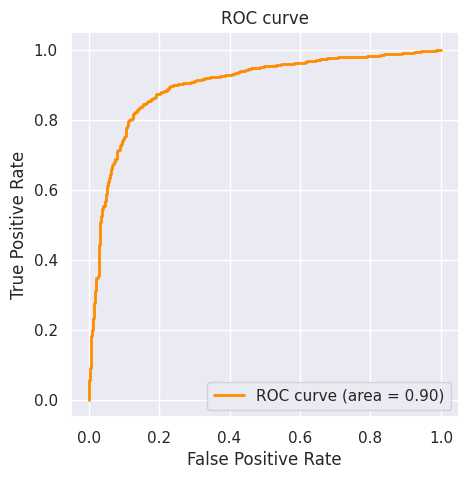

In [19]:
# plot
sns.set()
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()


In [24]:
fpr

array([0.        , 0.        , 0.        , 0.00100806, 0.00100806,
       0.00201613, 0.00201613, 0.00302419, 0.00302419, 0.00403226,
       0.00403226, 0.00504032, 0.00504032, 0.00604839, 0.00604839,
       0.00604839, 0.00604839, 0.00705645, 0.00705645, 0.00705645,
       0.00705645, 0.00806452, 0.00806452, 0.01008065, 0.01008065,
       0.01108871, 0.01108871, 0.01108871, 0.01108871, 0.01209677,
       0.01209677, 0.01310484, 0.01310484, 0.0141129 , 0.0141129 ,
       0.01612903, 0.01612903, 0.0171371 , 0.0171371 , 0.01814516,
       0.01814516, 0.01915323, 0.01915323, 0.02016129, 0.02016129,
       0.02116935, 0.02116935, 0.02217742, 0.02217742, 0.02318548,
       0.02318548, 0.02419355, 0.02419355, 0.02620968, 0.02620968,
       0.02721774, 0.02721774, 0.02822581, 0.02822581, 0.02923387,
       0.02923387, 0.03024194, 0.03024194, 0.03125   , 0.03125   ,
       0.03225806, 0.03225806, 0.03326613, 0.03326613, 0.03427419,
       0.03427419, 0.03528226, 0.03528226, 0.03629032, 0.03629